Hannah Weiser <br>
January 2023 <br>
Master's thesis
***
# Metric estimation from simulated point clouds

This notebook aims at estimating tree metrics from simulated point clouds of static and of moving trees. For now, it's shown exemplary for one tree point cloud.
The following metrics are included:
* Leaf area (using the Envelope Fitting method by [You et al. 2022](https://doi.org/10.1109/LGRS.2022.3214427))
* Leaf area index (using the Envelope Fitting method by [You et al. 2022](https://doi.org/10.1109/LGRS.2022.3214427)
* Gap fraction and simulated hemispherical photographs [add ref]()
* Canopy openness and LAI using simulated digital hemispherical photographs using [Gap Light Analyzer (GLA) Software](https://www.caryinstitute.org/science/our-scientists/dr-charles-d-canham/gap-light-analyzer-gla) ([Seidel et al. 2012](https://doi.org/10.1016/j.agrformet.2011.10.006))

* Leaf angles/Leaf angle distribution

* Geometric features based on eigenvalues

* Voxel-based metrics (e.g., number/ratio of empty voxels/empty enclosed voxels, points per voxel, etc.)

## Imports

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import laspy
import pandas as pd
from descartes import PolygonPatch
from alphashape import alphashape
import smallestenclosingcircle
from scripts import plot
import shapely
from osgeo import gdal
import rasterio as rio

## Merge and Load Point Cloud

In [2]:
# hardcode for now
pc_dir = r"H:\helios\output\moving_tree10_tls\2023-01-23_13-34-00"
survey_name = Path(pc_dir).parent.name
path_merged_pc = (Path(pc_dir) / f"{survey_name}.laz")

if not path_merged_pc.exists():
    print(f"Executing command:\nlasmerge -i {pc_dir}/*.laz -o {path_merged_pc.as_posix()} -faf")
    ! lasmerge -i {pc_dir}/*.laz -o {path_merged_pc.as_posix()} -faf
else:
    print(f"{path_merged_pc.as_posix()} already exists.")

H:/helios/output/moving_tree10_tls/2023-01-23_13-34-00/moving_tree10_tls.laz already exists.


In [3]:
traj_list = []
leg_names = []
for traj_file in Path(pc_dir).glob("*_trajectory.txt"):
    with open(traj_file) as f:
        t_coords = f.read().strip().split(" ")[:3]
        t_coords = [float(c) for c in t_coords]
        t_coords[2] += 1.7
    traj_list.append(np.array(t_coords))
    leg_names.append(traj_file.stem.replace("_trajectory", ""))

In [4]:
las = laspy.read(path_merged_pc)

coords = np.array([las.x, las.y, las.z]).T
classification = np.array([las.classification])
coords_leaves = coords[(classification == 1)[0], :]
coords_wood = coords[(classification == 0)[0], :]

## Plot Point Cloud

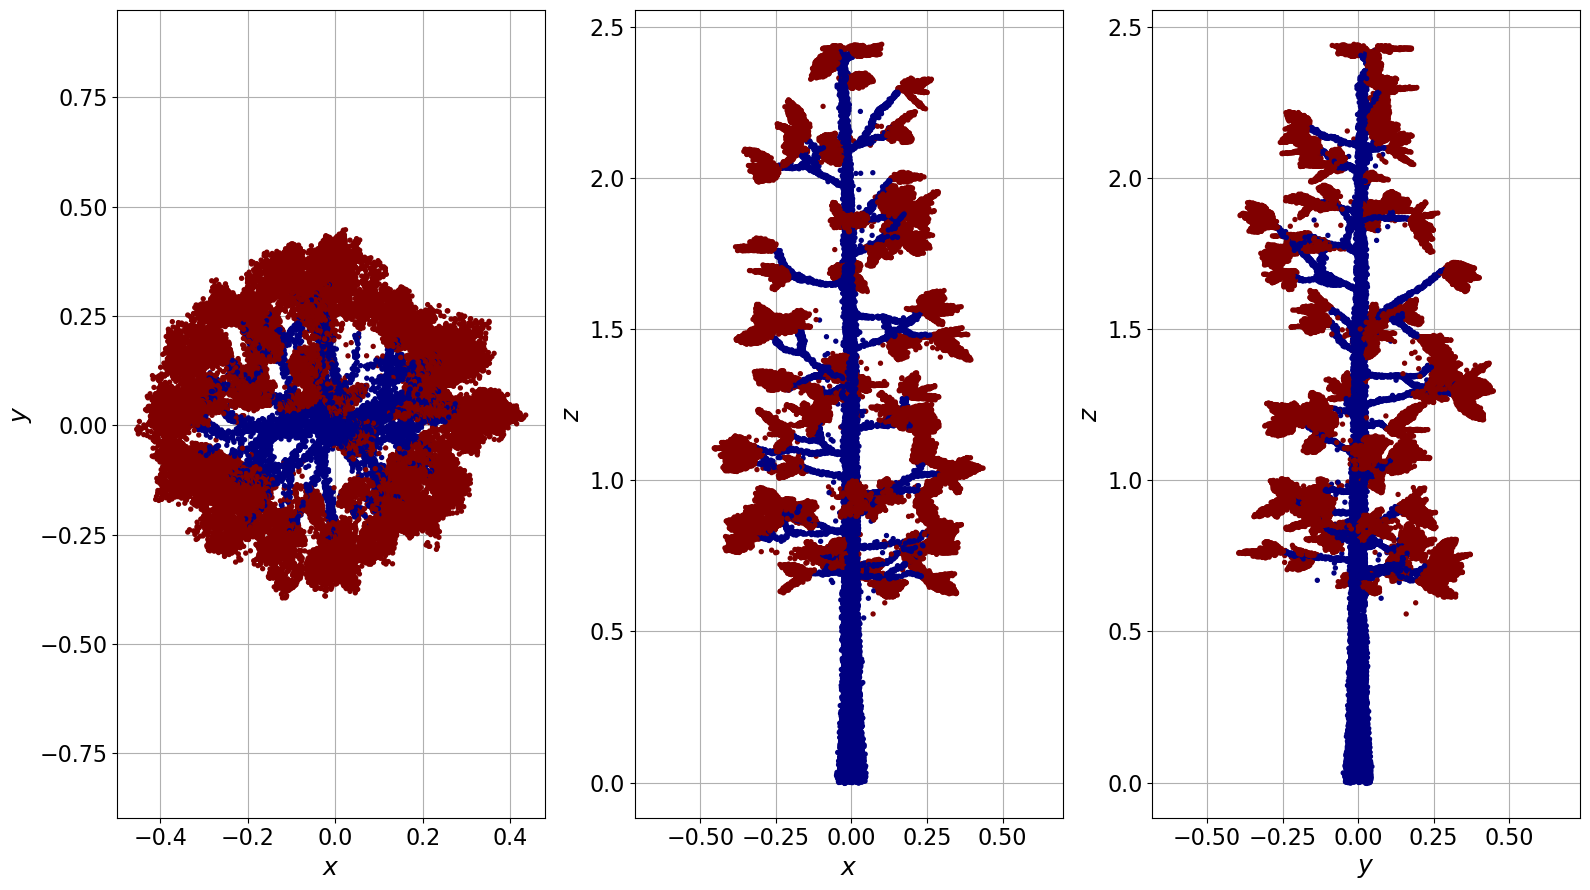

In [5]:
plot.plot_2dviews(coords[::10, :], c=classification[0][::10], s=8)

## 3D Alpha Shape

In [6]:
alpha = 70.0
alpha_shp = alphashape(coords_leaves, alpha)
alpha_shp.show()

In [7]:
print(f"One-sided leaf area calculated from alpha shape: {alpha_shp.area/2:.4f} m2")

One-sided leaf area calculated from alpha shape: 1.3663 m2


## 2D Convex Hull

0.5200 m2


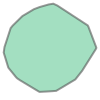

In [7]:
# convex hull is an alpha shape with alpha = 0.0
convex_hull_projected = alphashape(coords_leaves[::10, :2], 0.0)
print(f"{convex_hull_projected.area:.4f} m2")
convex_hull_projected

0.7391 m2


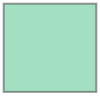

In [8]:
bb_xmin, bb_ymin, bb_xmax, bb_ymax = convex_hull_projected.bounds
convex_hull_projected_bbox = shapely.polygons([[bb_xmin, bb_ymin], [bb_xmin, bb_ymax], [bb_xmax, bb_ymax], [bb_xmax, bb_ymin]])
print(f"{convex_hull_projected_bbox.area:.4f} m2")
convex_hull_projected_bbox

In [9]:
xs, ys = convex_hull_projected.exterior.xy
points = np.stack((xs, ys), axis=1)
cx, cy, r = smallestenclosingcircle.make_circle(points)
circle_area = np.pi * r**2
print(f"{circle_area:.4f} m2")

0.6110 m2


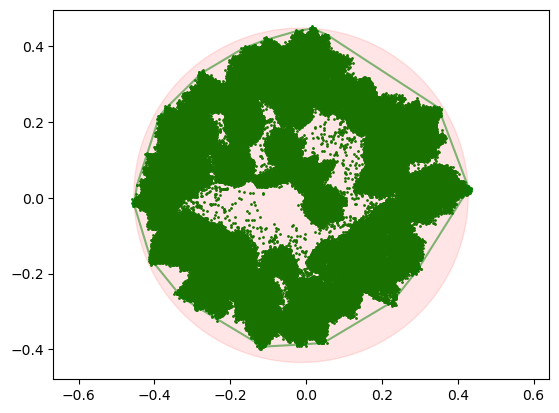

In [10]:
fig, ax = plt.subplots()
circle = plt.Circle((cx, cy), r, color='red', alpha=0.1)
ax.scatter(coords_leaves[:, 0], coords_leaves[:, 1], s=1.0, c="green")
ax.plot(*convex_hull_projected.exterior.xy, color="green", alpha=0.5)
ax.add_patch(circle)
plt.axis("equal")
plt.show()

## 2D Concave Hull

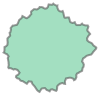

In [12]:
alpha_2d = 50.0
concave_hull_projected = alphashape(coords_leaves[::10, :2], alpha_2d)
concave_hull_projected

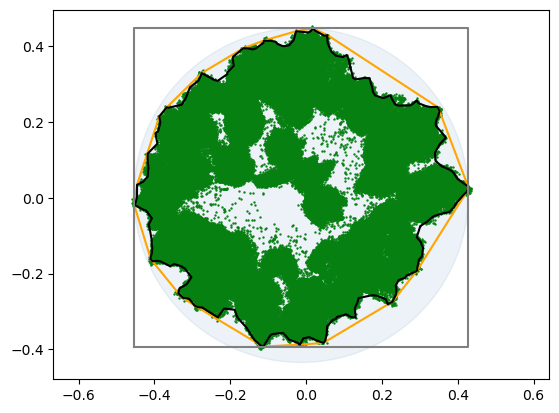

Area of the 2D alpha shape (alpha=50.0): 0.4673 m2


In [25]:
from shapely.geometry import Polygon, mapping
fig, ax = plt.subplots()
circle = plt.Circle((cx, cy), r, color='steelblue', alpha=0.1)
ax.scatter(coords_leaves[:, 0], coords_leaves[:, 1], s=0.5, c="green")
ax.plot(*convex_hull_projected.exterior.xy, color="orange")
ax.add_patch(circle)
ax.plot(*concave_hull_projected.exterior.xy, color="black")
ax.plot(*convex_hull_projected_bbox.exterior.xy, color="gray")
#ax.add_patch(PolygonPatch(mapping(concave_hull_projected), alpha=0.5))
plt.axis("equal")
plt.show()
print(f"Area of the 2D alpha shape (alpha={alpha_2d}): {concave_hull_projected.area:.4f} m2")

## Leaf Area Index (LAI)
Using the Envelope Fitting method by [You et al. 2022](https://doi.org/10.1109/LGRS.2022.3214427)

In [26]:
print(f"{alpha_shp.area / concave_hull_projected.area:.4f}")

5.8480


What if we use the bounding box rather than the concave hull?

In [27]:
print(f"{alpha_shp.area / convex_hull_projected_bbox.area:.4f}")

3.6973


What if we use the smallest enclosing circle rather than the concave hull?

In [28]:
print(f"{alpha_shp.area / circle_area:.4f}")

4.4724


## Leaf angles/Leaf angle distribution

tbd

## Geometric features

In [30]:
from jakteristics import las_utils, compute_features

In [36]:
features_jakteristics = ['planarity', 'linearity', 'sphericity', 'verticality']
search_radius = 0.1  # check; maybe compute for several search radii
n_threads = 4
dim_features = compute_features(coords_leaves, search_radius=search_radius, num_threads=n_threads,
                                feature_names=features_jakteristics)

### Plot geometric features

#### Planarity

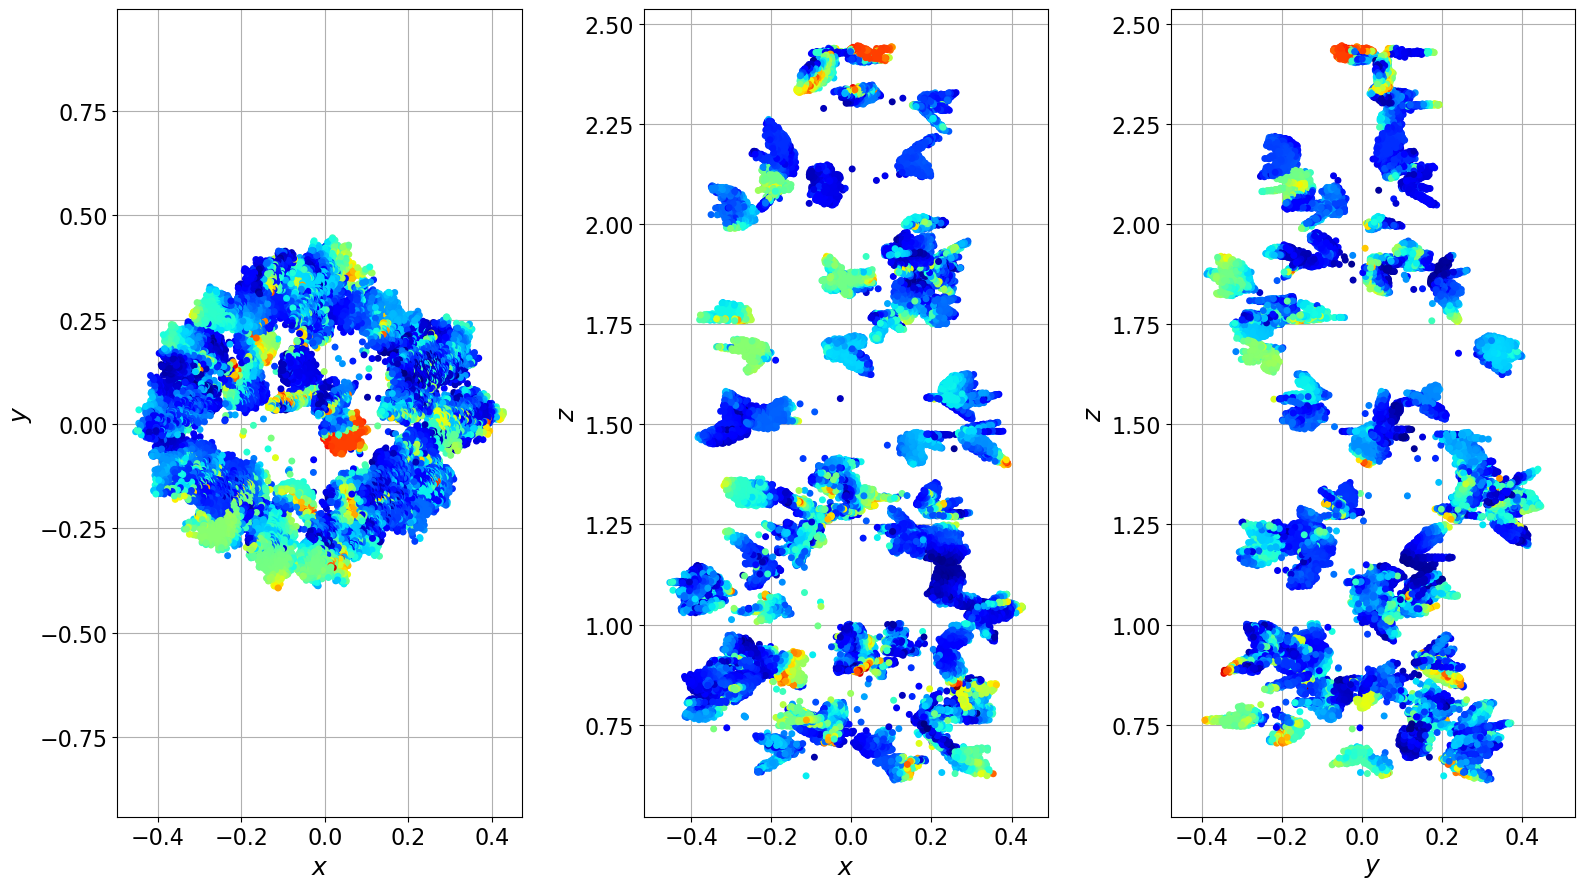

In [37]:
plot.plot_2dviews(coords_leaves[::10, :], c=dim_features[::10, 0])

#### Linearity

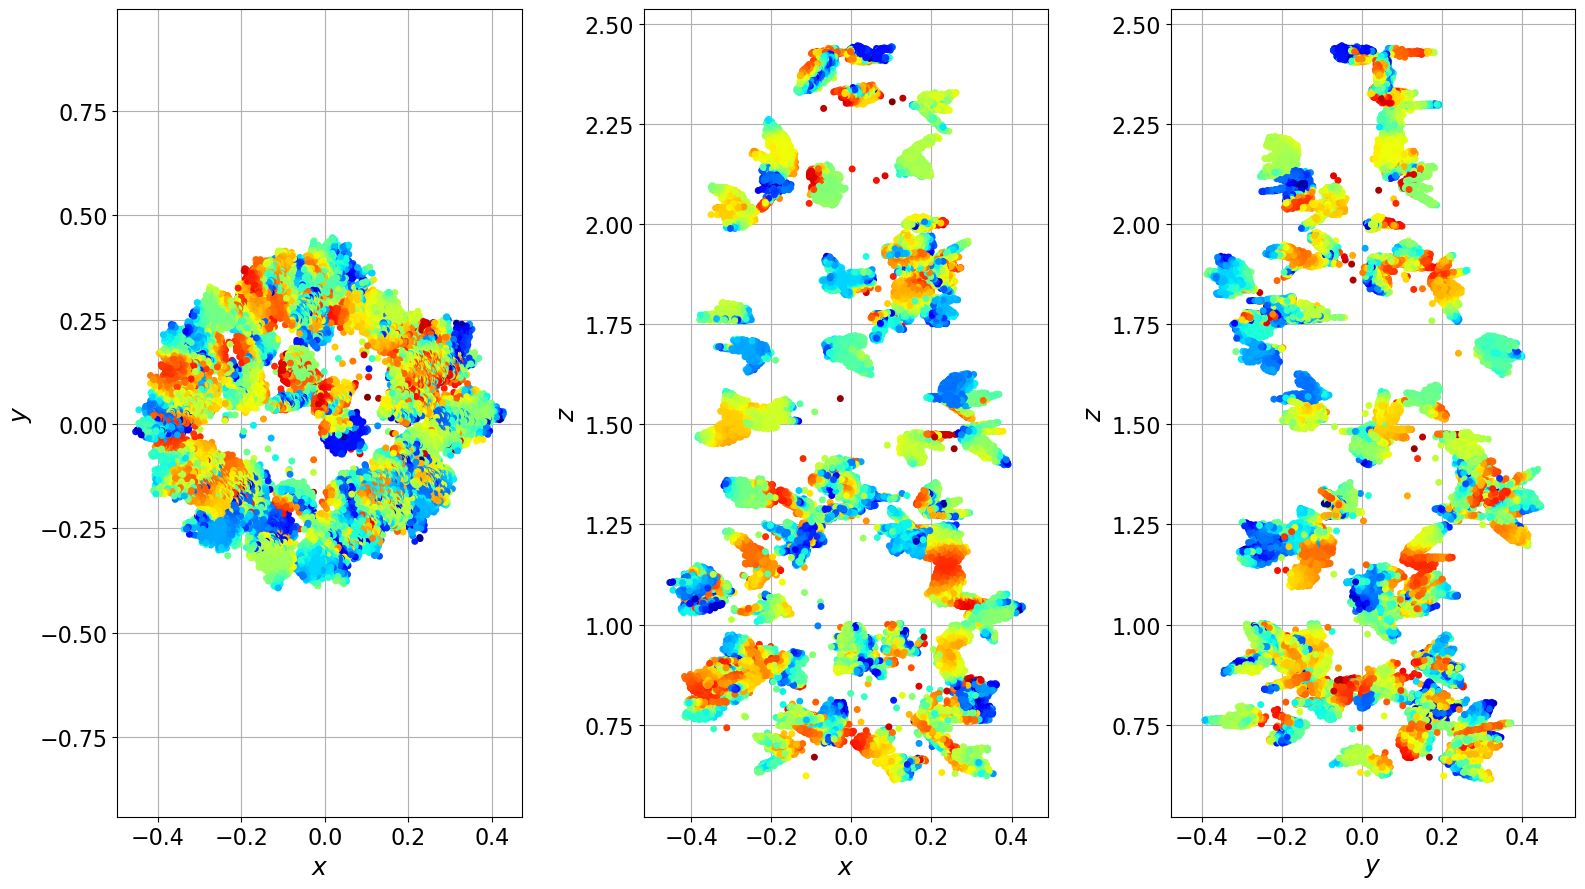

In [38]:
plot.plot_2dviews(coords_leaves[::10, :], c=dim_features[::10, 1])

#### Sphericity

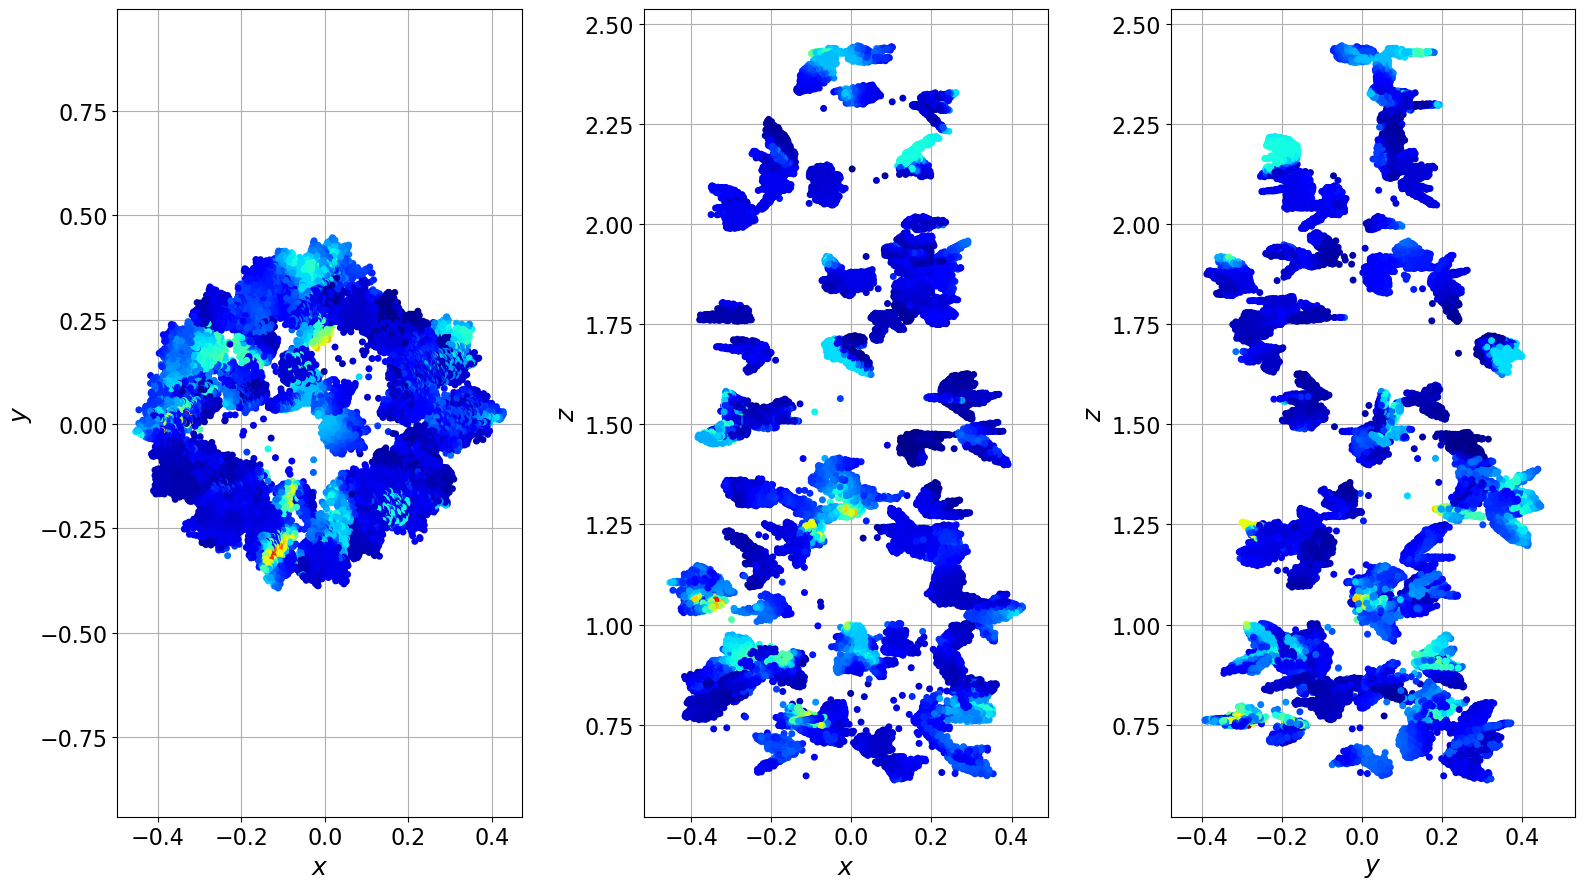

In [35]:
plot.plot_2dviews(coords_leaves[::10, :], c=dim_features[::10, 2])

#### Verticality

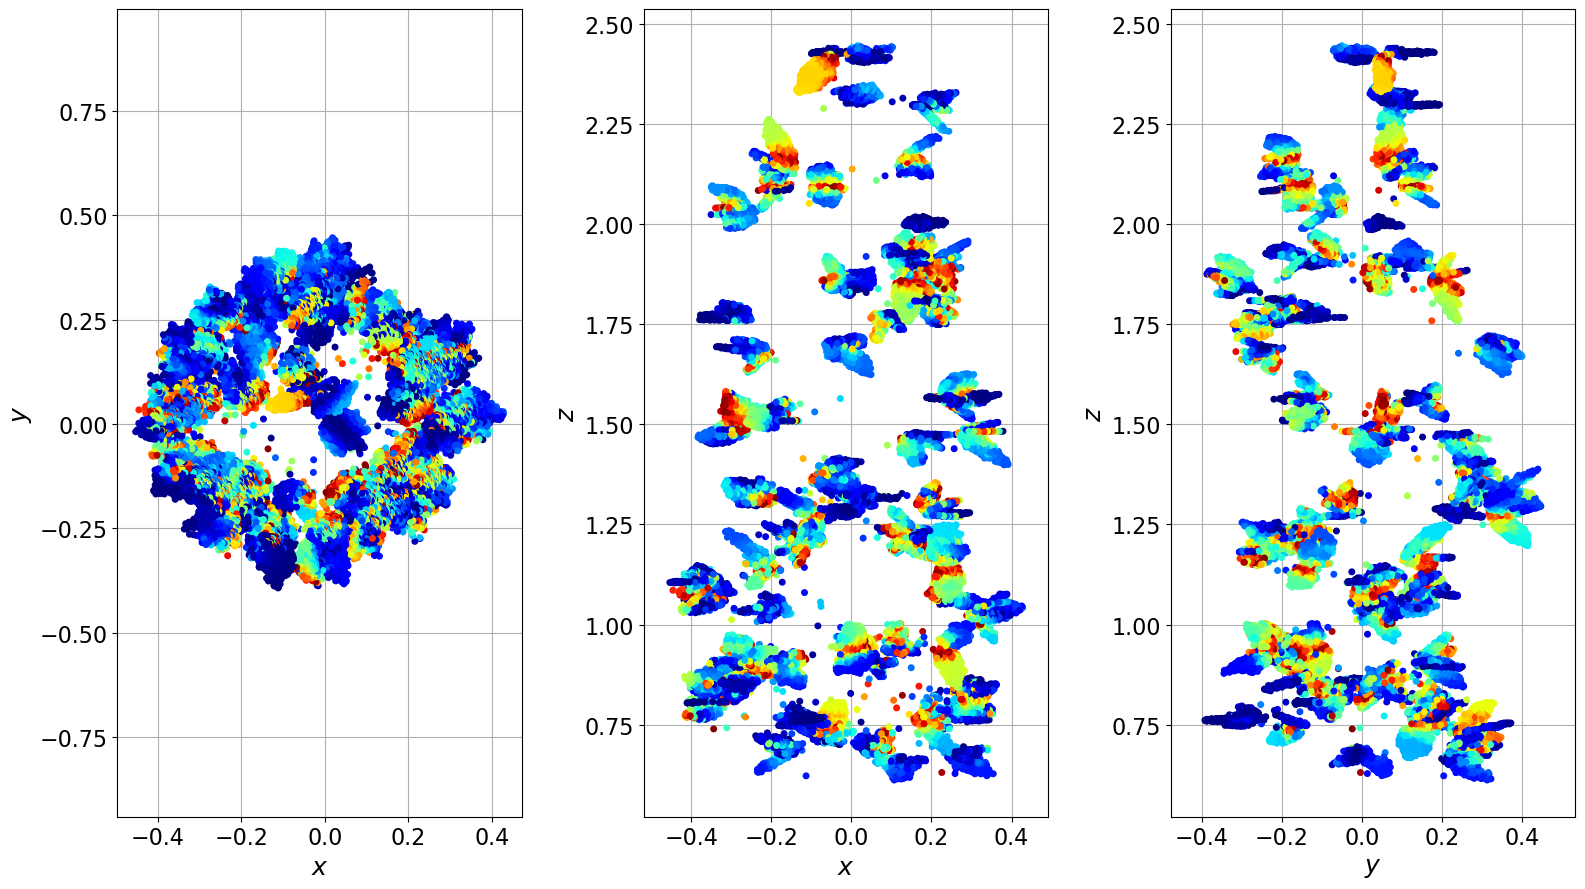

In [22]:
plot.plot_2dviews(coords_leaves[::10, :], c=dim_features[::10, 3])

### Summary statistics of geometric features

In [40]:
dim_feats_df = pd.DataFrame(dim_features, columns=features_jakteristics)

In [41]:
dim_feats_df.head()

planarity  linearity  sphericity  verticality
0   0.364979   0.370870    0.264152     0.424127
1   0.416559   0.285993    0.297448     0.404732
2   0.379422   0.344420    0.276158     0.405860
3   0.324461   0.435281    0.240258     0.394624
4   0.297815   0.473033    0.229151     0.375942

In [59]:
print(f"Mean:\n{dim_feats_df.mean()}\n")
print(f"Median:\n{dim_feats_df.median()}\n")
print(f"Standard deviation:\n{dim_feats_df.std()}\n")

dim_feats_df.mean().planarity

Mean:
planarity      0.221584
linearity      0.506356
sphericity     0.272060
verticality    0.372669
dtype: float32

Median:
planarity      0.192093
linearity      0.526872
sphericity     0.251886
verticality    0.277306
dtype: float32

Standard deviation:
planarity      0.131797
linearity      0.180742
sphericity     0.128086
verticality    0.284089
dtype: float32



0.22158352

### Histograms of geometric features

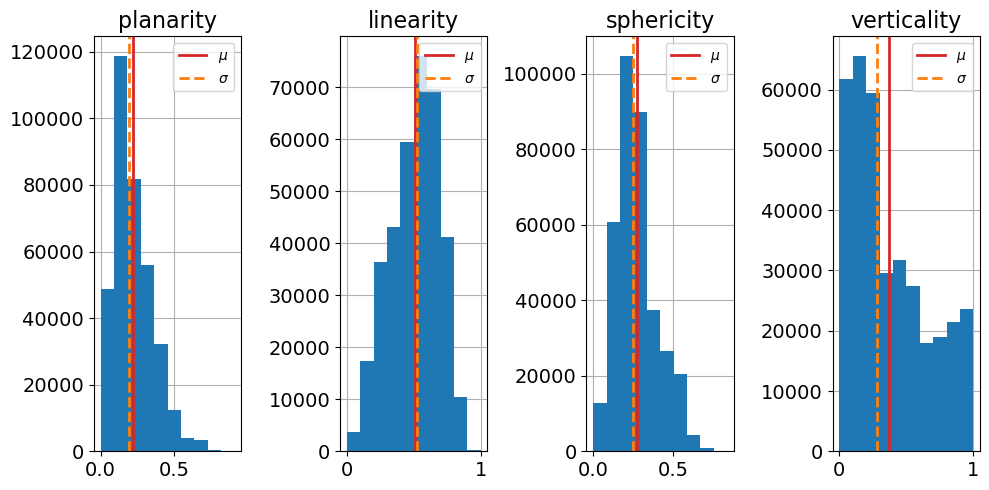

In [48]:
plot.plot_features_histogram(dim_features, features=features_jakteristics, figsize=(10, 5))

## Voxel-based features

### Ratio of filled to empty voxels

In [49]:
from scripts import voxelizer

In [50]:
vox_size = 0.05
vox = voxelizer.Voxelizer(coords, voxel_size=vox_size)
centers, idxs, voxel_idx, closest_idx, local_origin = vox.voxelize()

In [57]:
pts_per_vox = np.array([len(idxs[i]) for i in range(len(voxel_idx))])
print(np.mean(pts_per_vox))
print(np.median(pts_per_vox))
print(np.min(pts_per_vox))
print(np.max(pts_per_vox))
print(np.std(pts_per_vox))

236.75975836431226
58.0
1
2255
351.28522709954694


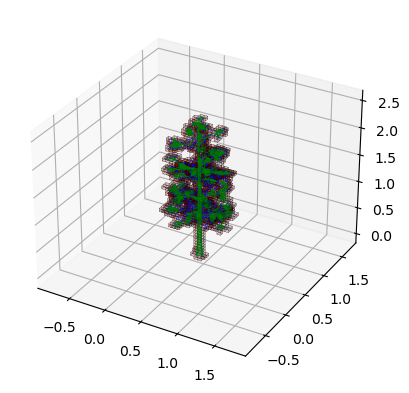

In [30]:
voxelizer.plot_result(coords, voxel_idx, closest_idx, vox_size, vox_size, vox_size, local_origin)

In [31]:
mins = np.min(voxel_idx, axis=0)
maxes = np.max(voxel_idx, axis=0)
x_range = int((maxes[0] - mins[0]) / 1) + 1
y_range = int((maxes[1] - mins[1]) / 1) + 1
z_range = int((maxes[2] - mins[2]) / 1) + 1
# prepare some coordinates
voxels = np.zeros((x_range, y_range, z_range), bool)
for idx in voxel_idx:
    idxlist = (idx - mins).astype(int).tolist()
    voxels[idxlist[0], idxlist[1], idxlist[2]] = True

In [32]:
print(f"{np.count_nonzero(voxels)} of {np.size(voxels)} voxels ({vox_size} m | {vox_size} m | {vox_size} m) in voxel space contain points.")
print(f"Percentage of filled voxels: {np.count_nonzero(voxels)/np.size(voxels)*100:.2f}%")

2152 of 17100 voxels (0.05 m | 0.05 m | 0.05 m) in voxel space contain points.
Percentage of filled voxels: 12.58%


In [33]:
for vox_size in [0.1, 0.05, 0.02, 0.01]:
    vox = voxelizer.Voxelizer(coords, voxel_size=vox_size)
    centers, idxs, voxel_idx, closest_idx, local_origin = vox.voxelize()
    mins = np.min(voxel_idx, axis=0)
    maxes = np.max(voxel_idx, axis=0)
    x_range = int((maxes[0] - mins[0]) / 1) + 1
    y_range = int((maxes[1] - mins[1]) / 1) + 1
    z_range = int((maxes[2] - mins[2]) / 1) + 1
    # prepare some coordinates
    voxels = np.zeros((x_range, y_range, z_range), bool)
    for idx in voxel_idx:
        idxlist = (idx - mins).astype(int).tolist()
        voxels[idxlist[0], idxlist[1], idxlist[2]] = True
    print(f"{np.count_nonzero(voxels)} of {np.size(voxels)} voxels ({vox_size} m | {vox_size} m | {vox_size} m) in voxel space contain points.")
    print(f"Percentage of filled voxels: {np.count_nonzero(voxels)/np.size(voxels)*100:.2f}%\n")

574 of 2250 voxels (0.1 m | 0.1 m | 0.1 m) in voxel space contain points.
Percentage of filled voxels: 25.51%

2151 of 17100 voxels (0.05 m | 0.05 m | 0.05 m) in voxel space contain points.
Percentage of filled voxels: 12.58%

11453 of 238005 voxels (0.02 m | 0.02 m | 0.02 m) in voxel space contain points.
Percentage of filled voxels: 4.81%

42476 of 1904040 voxels (0.01 m | 0.01 m | 0.01 m) in voxel space contain points.
Percentage of filled voxels: 2.23%



## Height and distribution metrics

In [34]:
height_vals = coords[:, 2]
qq = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
hq = np.zeros(len(qq), dtype=float)
for idx, qq in enumerate(qq):
    hq[idx] = np.percentile(height_vals, qq)
print(f"""Basic statistics:
Mean: {np.nanmean(height_vals):.4f}
Median: {np.nanmedian(height_vals):.4f}
Height quantiles: {hq}
     """)

Basic statistics:
Mean: 1.3375
Median: 1.2776
Height quantiles: [0.7324 0.8568 0.9689 1.1247 1.2776 1.4419 1.6557 1.8929 2.1362]
     


## Return number metrics

In [35]:
nor = las.number_of_returns
rn = las.return_number
print(f"Number of multiple returns: {np.count_nonzero((nor > 1) & (rn == 1))} (of {np.count_nonzero(rn == 1)} pulses)")

Number of multiple returns: 21 (of 509486 pulses)


## Hemispherial Photographs and Gap Fraction

In [36]:
las_photo_cam_sim = "H:/lasPhotoCamSIM/lasPhotoCamSIM.exe"
cam_pos = "0,0,0\n"
cam_pos_file = Path(pc_dir) / "cam_pos.txt"
with open(cam_pos_file, "w") as f:
    f.write("X,Y,Z\n")
    f.write(cam_pos)

In [37]:
log = !{las_photo_cam_sim} -i {path_merged_pc.as_posix()} -loc {cam_pos_file.as_posix()} -log -orast 900

In [38]:
search_string = "Written_file"
outfile_gap_frac = list(Path(pc_dir).glob("cam_pos*.out"))[0]
fname = [e for e in log if e.startswith("Filename")][0].strip().replace("Filename=", "")
fname

'H:/helios/output/moving_tree10_tls/2023-01-23_13-34-00/cam_pos.txt.plot001_non_zenCut89_sz900_log10.asc'

In [39]:
src = rio.open(fname, driver="AAIGrid")

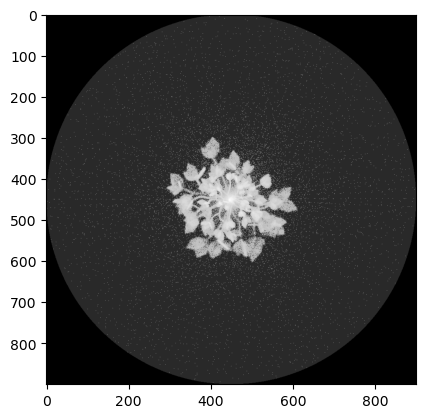

In [40]:
plt.imshow(src.read(1), cmap='Greys_r')
plt.show()

In [41]:
with open(outfile_gap_frac, "r") as f:
    gap_frac = float(f.readlines()[1].strip().split(",")[-1])
gap_frac

91.884369